In [1]:
from importlib import reload
import abbot.rotation
reload(abbot.rotation)
from abbot.gradientOperator import gradientOperatorType1
import Zernike
from NumRec import circle
import numpy
import pylab

In [2]:
N=30
aperture=circle(N+2,N//2)
gOp=gradientOperatorType1(aperture)
gM=gOp.returnOp()
gM_i=numpy.linalg.pinv(gM)
rot_angle=16 # degrees

In [3]:
# inputV=[ amp*Zernike.anyZernike(i+2,N+3,clip=0).ravel().take(gOp.illuminatedCornersIdx)
#        for (i,amp) in enumerate(
#                numpy.random.normal(0,1,size=gOp.numberPhases//2+100+100)
# #           [0,0,1,0,0,0,0,0,0,1]
#            ) ]
# inputV=array(inputV).sum(0)
from kolmogorov import TwoScreens
inputV=TwoScreens(N+3,4)[0].ravel().take(gOp.illuminatedCornersIdx)
inputV-=inputV.mean()

In [4]:
unrot_ap,rot_ap=numpy.zeros(gOp.n_),numpy.zeros(gOp.n_)

---
# Poke on a square support

In [5]:
blank=numpy.zeros(gOp.n_)
pokes=[]
for i in gOp.illuminatedCornersIdx:
    blank.ravel()[i]=1
    pokes.append(blank.copy())
    blank.ravel()[i]=0
pokes=numpy.array(pokes)
print(f"pokes.shape={pokes.shape}")
##
#pylab.imshow( (pokes[::1].sum(0)) )
#pylab.plot( (wfaperture*pokes[::1].sum(0)).take(gOp.illuminatedCornersIdx),'o' )

pokes.shape=(777, 33, 33)


# `scipy` rotation function

Use the scipy function `scipy.ndimage.rotate` to rotate the pokes on the square support i.e. a mapping from point-by-point wavefront sampling on the square support to an equivalent rotated sampling. Note that this function has an inverted y-axis or equivalently a left-handed coordinate system.

In [6]:
rotSOp=abbot.rotation.rotationScipyOperator(rot_angle,aperture)
rotSM=rotSOp.returnOp()
srotSOp=abbot.rotation.slopeRotationScipyOperator(rot_angle,aperture)
srotSM=srotSOp.returnOp()

In [16]:
from scipy.ndimage import rotate 
# rot_pokes_half=rotate(pokes,-rot_angle/2.0,(1,2),False,order=1,mode='constant',prefilter=False) # forwards from 0 to +rot_angle/2
# rot_pokes_full=rotate(rot_pokes_half,rot_angle,(1,2),False,order=1,mode='constant',prefilter=False) # backwards from +rot_angle/2 to -rot_angle/2
rot_pokes_full=rotate(pokes,rot_angle,(1,2),False,order=1,mode='constant',prefilter=False) # backwards from 0 to -rot_angle
    # \/ the operator rotatddes from the final rotated sampling backwards in angle--anti-rotation--hence the -ve angle above
rotOpM=rot_pokes_full.reshape([gOp.numberPhases,-1]).take(gOp.illuminatedCornersIdx,1) 
rotSlopesOpM=gM@rotOpM@gM_i

## Results

In [7]:
ip_slopesV=gM@inputV
norot_slopesV=ip_slopesV
rot_slopesV=srotSM@ip_slopesV
rot_opV=rotSM@inputV
norot_opV=gM_i@norot_slopesV#ip_slopesV
rot_ap*=0
norot_ap=rot_ap.copy()
rot_ap.ravel()[gOp.illuminatedCornersIdx]=rot_opV
norot_ap.ravel()[gOp.illuminatedCornersIdx]=norot_opV
unrot_ap.ravel()[gOp.illuminatedCornersIdx]=inputV
##
print(f"var{{I/P slopes}}={ip_slopesV.var():.3e}")
print(f"var{{rot slopes}}={rot_slopesV.var():.3e}")
print(f"var{{n/r slopes}}={norot_slopesV.var():.3e}")
#
print(f"var{{I/P w/front}}={inputV.var():.3e}")
print(f"var{{rot w/front}}={rot_opV.var():.3e}")
print(f"var{{n/r w/front}}={norot_opV.var():.3e}")


var{I/P slopes}=5.671e-01
var{rot slopes}=5.394e-01
var{n/r slopes}=5.671e-01
var{I/P w/front}=1.287e+01
var{rot w/front}=1.204e+01
var{n/r w/front}=1.287e+01


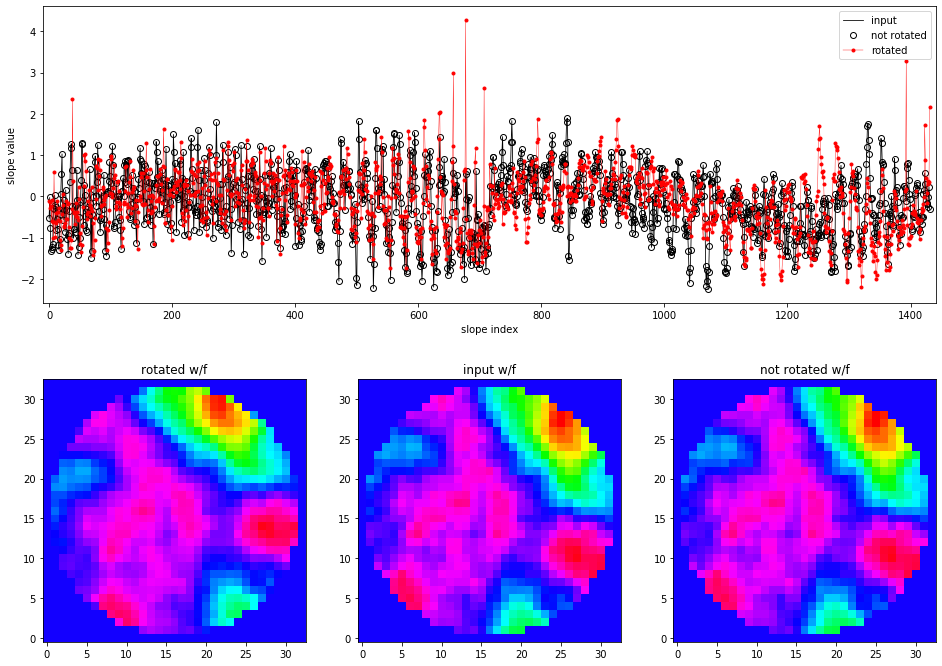

In [8]:
if 'fig2' in dir(): del fig2
fig2=pylab.figure(figsize=(16,12))
spst=pylab.subplot(2,1,1) # have to do it this way
spsl=pylab.subplot(2,3,4)
spsm=pylab.subplot(2,3,5)
spsr=pylab.subplot(2,3,6)
#
spst.plot(ip_slopesV,'k',lw=0.8, label='input')
spst.plot(norot_slopesV,'ko',markerfacecolor='none', label='not rotated')
spst.plot(rot_slopesV,'r.-',lw=0.4,label='rotated')
fac=1;lims=unrot_ap.min()*fac,unrot_ap.max()*fac
spsl.imshow( rot_ap,vmax=lims[1],vmin=lims[0], cmap='hsv' )
spsm.imshow( unrot_ap,vmax=lims[1],vmin=lims[0], cmap='hsv'  )
spsr.imshow( norot_ap,vmax=lims[1],vmin=lims[0], cmap='hsv'  )
#
spst.set_xlabel("slope index")
spst.set_ylabel("slope value")
spst.set_xlim(0-10,1431+10)
spst.legend(loc='best')
spsl.set_title("rotated w/f")
spsm.set_title("input w/f")
spsr.set_title("not rotated w/f");

# Explicit rotation matrix

In [9]:
rotEOp=abbot.rotation.rotationExplicitOperator(rot_angle,aperture)
rotEM=rotEOp.returnOp()
srotEOp=abbot.rotation.slopeRotationExplicitOperator(rot_angle,aperture)
srotEM=srotEOp.returnOp()

## Results

In [10]:
ip_slopesV=gM@inputV
norot_slopesV=ip_slopesV
norot_opV=gM_i@norot_slopesV#ip_slopesV
rot_opV=rotEM@inputV
rot_slopesV=srotEM@ip_slopesV
rot_ap*=0
norot_ap=rot_ap.copy()
rot_ap.ravel()[gOp.illuminatedCornersIdx]=rot_opV
norot_ap.ravel()[gOp.illuminatedCornersIdx]=norot_opV
unrot_ap.ravel()[gOp.illuminatedCornersIdx]=inputV
##
print(f"var{{I/P slopes}}={ip_slopesV.var():.3e}")
print(f"var{{rot slopes}}={rot_slopesV.var():.3e}")
print(f"var{{n/r slopes}}={norot_slopesV.var():.3e}")
#
print(f"var{{I/P w/front}}={inputV.var():.3e}")
print(f"var{{rot w/front}}={rot_opV.var():.3e}")
print(f"var{{n/r w/front}}={norot_opV.var():.3e}")


var{I/P slopes}=5.671e-01
var{rot slopes}=5.343e-01
var{n/r slopes}=5.671e-01
var{I/P w/front}=1.287e+01
var{rot w/front}=1.204e+01
var{n/r w/front}=1.287e+01


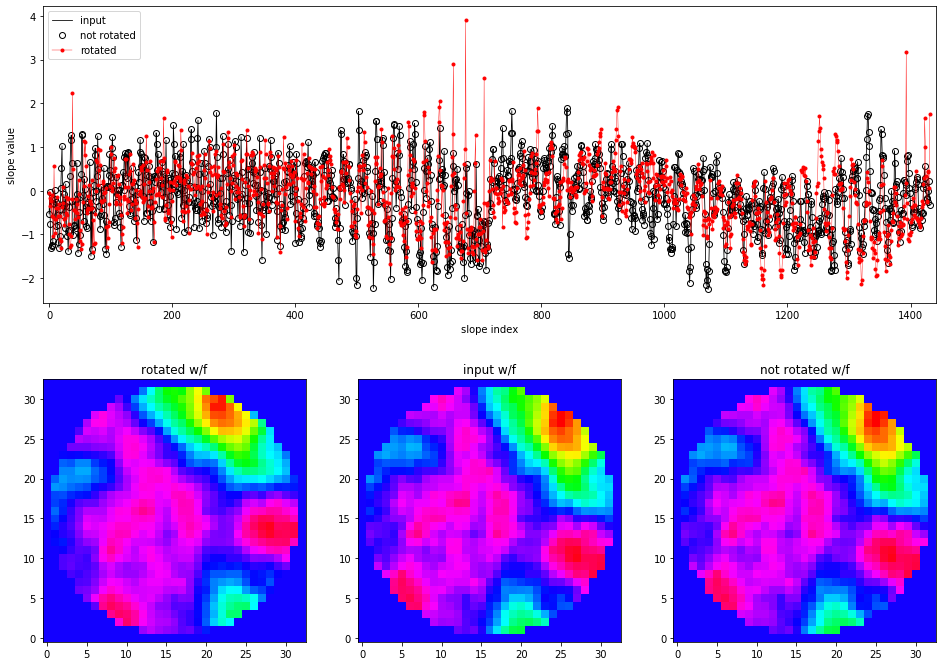

In [11]:
if 'fig2' in dir(): del fig2
fig2=pylab.figure(figsize=(16,12))
spst=pylab.subplot(2,1,1) # have to do it this way
spsl=pylab.subplot(2,3,4)
spsm=pylab.subplot(2,3,5)
spsr=pylab.subplot(2,3,6)
#
spst.plot(ip_slopesV,'k',lw=0.8, label='input')
spst.plot(norot_slopesV,'ko',markerfacecolor='none', label='not rotated')
spst.plot(rot_slopesV,'r.-',lw=0.4,label='rotated')
fac=1;lims=unrot_ap.min()*fac,unrot_ap.max()*fac
spsl.imshow( rot_ap,vmax=lims[1],vmin=lims[0], cmap='hsv' )
spsm.imshow( unrot_ap,vmax=lims[1],vmin=lims[0], cmap='hsv'  )
spsr.imshow( norot_ap,vmax=lims[1],vmin=lims[0], cmap='hsv'  )
#
spst.set_xlabel("slope index")
spst.set_ylabel("slope value")
spst.set_xlim(0-10,1431+10)
spst.legend(loc='best')
spsl.set_title("rotated w/f")
spsm.set_title("input w/f")
spsr.set_title("not rotated w/f");

# `scipy` affine transform matrix

In [12]:
rotAOp=abbot.rotation.affineScipyOperator(
    angle=0,subapMask=aperture,translate=[-15,0])
rotAM=rotAOp.returnOp()
srotAOp=abbot.rotation.slopeAffineScipyOperator(
    angle=0,subapMask=aperture,translate=[-15,0])
srotAM=srotAOp.returnOp()

## Results

In [13]:
ip_slopesV=gM@inputV
norot_slopesV=ip_slopesV
norot_opV=gM_i@norot_slopesV
rot_opV=rotAM@inputV
rot_slopesV=srotAM@ip_slopesV
rot_ap*=0
norot_ap=rot_ap.copy()
rot_ap.ravel()[gOp.illuminatedCornersIdx]=rot_opV
norot_ap.ravel()[gOp.illuminatedCornersIdx]=norot_opV
unrot_ap.ravel()[gOp.illuminatedCornersIdx]=inputV
##
print(f"var{{I/P slopes}}={ip_slopesV.var():.3e}")
print(f"var{{rot slopes}}={rot_slopesV.var():.3e}")
print(f"var{{n/r slopes}}={norot_slopesV.var():.3e}")
#
print(f"var{{I/P w/front}}={inputV.var():.3e}")
print(f"var{{rot w/front}}={rot_opV.var():.3e}")
print(f"var{{n/r w/front}}={norot_opV.var():.3e}")


var{I/P slopes}=5.671e-01
var{rot slopes}=2.367e-01
var{n/r slopes}=5.671e-01
var{I/P w/front}=1.287e+01
var{rot w/front}=1.710e+00
var{n/r w/front}=1.287e+01


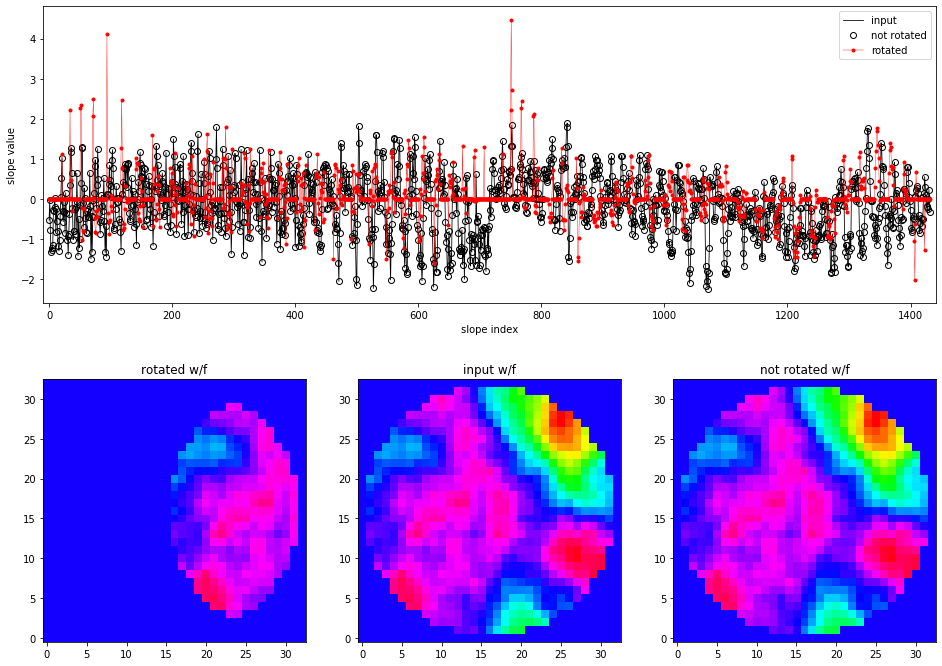

In [14]:
if 'fig2' in dir(): del fig2
fig2=pylab.figure(figsize=(16,12))
spst=pylab.subplot(2,1,1) # have to do it this way
spsl=pylab.subplot(2,3,4)
spsm=pylab.subplot(2,3,5)
spsr=pylab.subplot(2,3,6)
#
spst.plot(ip_slopesV,'k',lw=0.8, label='input')
spst.plot(norot_slopesV,'ko',markerfacecolor='none', label='not rotated')
spst.plot(rot_slopesV,'r.-',lw=0.4,label='rotated')
fac=1;lims=unrot_ap.min()*fac,unrot_ap.max()*fac
spsl.imshow( rot_ap,vmax=lims[1],vmin=lims[0], cmap='hsv' )
spsm.imshow( unrot_ap,vmax=lims[1],vmin=lims[0], cmap='hsv'  )
spsr.imshow( norot_ap,vmax=lims[1],vmin=lims[0], cmap='hsv'  )
#
spst.set_xlabel("slope index")
spst.set_ylabel("slope value")
spst.set_xlim(0-10,1431+10)
spst.legend(loc='best')
spsl.set_title("rotated w/f")
spsm.set_title("input w/f")
spsr.set_title("not rotated w/f");

# Covariance based rotation matrix

If we say the rotation of slopes is represented by $T$, then,

$$\tilde{s}=T_{\tilde{s}s}s$$

which leads to,

$$\tilde{s}_k.s_k=T_{\tilde{s}s}{s}_k.s_k$$

and then ultimately,

$$T_{\tilde{s}s}=C_{\tilde{s}s}.C^{-1}_{{s}s}$$

<div class="alert alert-block alert-warning"><b>WARNING:</b> Still doing anti-rotation for some reason
</div>

### Poke-based slopes

In [17]:
ipGVs=gM@pokes.reshape([gOp.numberPhases,-1])
rot_ipGVs=gM@rot_pokes_full.reshape([gOp.numberPhases,-1])

### Kolmogorov-based slopes

In [18]:
C_ss=ipGVs@ipGVs.T
C_stildes=rot_ipGVs@ipGVs.T
C_ss_i=numpy.linalg.pinv(C_ss,1e-9)
rotOpM=(C_stildes@C_ss_i)

## Results

In [19]:
ip_slopesV=gM@inputV
norot_slopesV=ip_slopesV
rot_slopesV=rotOpM@ip_slopesV
rot_opV=gM_i@rot_slopesV
norot_opV=gM_i@norot_slopesV#ip_slopesV
rot_ap*=0
norot_ap=rot_ap.copy()
rot_ap.ravel()[gOp.illuminatedCornersIdx]=rot_opV
norot_ap.ravel()[gOp.illuminatedCornersIdx]=norot_opV
unrot_ap.ravel()[gOp.illuminatedCornersIdx]=inputV
##
print(f"var{{I/P slopes}}={ip_slopesV.var():.3e}")
print(f"var{{rot slopes}}={rot_slopesV.var():.3e}")
print(f"var{{n/r slopes}}={norot_slopesV.var():.3e}")
#
print(f"var{{I/P w/front}}={inputV.var():.3e}")
print(f"var{{rot w/front}}={rot_opV.var():.3e}")
print(f"var{{n/r w/front}}={norot_opV.var():.3e}")


var{I/P slopes}=5.671e-01
var{rot slopes}=5.394e-01
var{n/r slopes}=5.671e-01
var{I/P w/front}=1.287e+01
var{rot w/front}=1.204e+01
var{n/r w/front}=1.287e+01


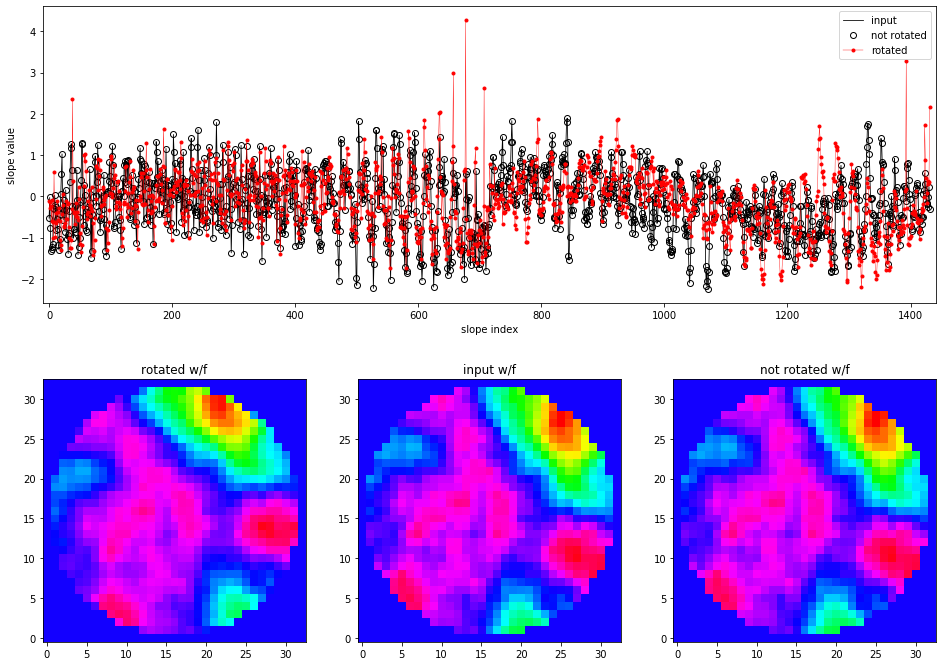

In [20]:
if 'fig1' in dir(): del fig1
fig1=pylab.figure(figsize=(16,12))
spst=pylab.subplot(2,1,1) # have to do it this way
spsl=pylab.subplot(2,3,4)
spsm=pylab.subplot(2,3,5)
spsr=pylab.subplot(2,3,6)
#
spst.plot(ip_slopesV,'k',lw=0.8, label='input')
spst.plot(norot_slopesV,'ko',markerfacecolor='none', label='not rotated')
spst.plot(rot_slopesV,'r.-',lw=0.4,label='rotated')
fac=1;lims=unrot_ap.min()*fac,unrot_ap.max()*fac
spsl.imshow( rot_ap,vmax=lims[1],vmin=lims[0], cmap='hsv' )
spsm.imshow( unrot_ap,vmax=lims[1],vmin=lims[0], cmap='hsv'  )
spsr.imshow( norot_ap,vmax=lims[1],vmin=lims[0], cmap='hsv'  )
#
spst.set_xlabel("slope index")
spst.set_ylabel("slope value")
spst.set_xlim(0-10,1431+10)
spst.legend(loc='best')
spsl.set_title("rotated w/f")
spsm.set_title("input w/f")
spsr.set_title("not rotated w/f");

# Rotation based on orthogonal wavefront functions

As we know that we can make functions based on analytic formulae (Zernike, Fourier basis) that can be rotated, this recipe is,
1. Generate the basis from each function,
2. Orthogonalise these basis functions,
3. Decompose the input wavefront,
4. Reconstruct using the decomposition but onto rotated functions' basis.

In [21]:
bM,rot_bM=[],[]
import Zernike
zernOrder=[]
iI,nI,mI,nModTwoI=0,1,2,3
for i in range(1,gOp.numberPhases//2):
    paramV=[i]+Zernike.zernNumToDegFreq(i) # order is; i,n,m,nModTwo
    paramV=[ paramV[idx] for idx in (nModTwoI,nI,mI,iI) ]
    zernOrder.append( paramV )

iI,nI,mI,nModTwoI=3,1,2,0
    
max_n=int((N+1))
max_m=int((N+1)*numpy.pi/2)
zernOrder.sort()
for paramV in zernOrder:
    i,n,m=[paramV[idx] for idx in (iI,nI,mI)]
    if n>=max_n or m>=max_m:
        continue
    bM.append(     Zernike.anyZernike(i,N+3,clip=0,rotation=0        ).ravel().take(gOp.illuminatedCornersIdx) )
    rot_bM.append( Zernike.anyZernike(i,N+3,clip=0,rotation=rot_angle).ravel().take(gOp.illuminatedCornersIdx) )

In [24]:
bM    =numpy.array(    bM).reshape([-1,gOp.numberPhases]).transpose()
rot_bM=numpy.array(rot_bM).reshape([-1,gOp.numberPhases]).transpose()
print(f"Size of bM={bM.shape}")

Size of bM=(777, 387)


In [25]:
# want ortho-normalized basis functions, b'
# have bT.b!=I
# if have b'.LT=b then L.b'T.b'.LT=L.LT=bT.b; L from Cholesky decomposition
# then b'=b.LT^-1

In [26]:
if not type(bM) is numpy.ndarray:
    bM,rot_bM=array(bM).T,array(rot_bM).T
##
bTb=bM.T@bM
bLM=numpy.linalg.cholesky(bTb)
svd_coff=3e-2
bLM_i=numpy.linalg.pinv(bLM,1e-2)
##
b_dashM,rb_dashM=bM@bLM_i.T,rot_bM@bLM_i.T
rotBFOpM=rb_dashM@b_dashM.T
norotBFOpM=b_dashM@b_dashM.T

## Results

In [27]:
ip_slopesV=gM@inputV
norot_opV=norotBFOpM@inputV
norot_slopesV=gM@norot_opV
rot_opV=rotBFOpM@inputV
rot_slopesV=gM@rot_opV
rot_ap*=0
norot_ap=rot_ap.copy()
rot_ap.ravel()[gOp.illuminatedCornersIdx]=rot_opV
norot_ap.ravel()[gOp.illuminatedCornersIdx]=norot_opV
unrot_ap.ravel()[gOp.illuminatedCornersIdx]=inputV
##
print(f"var{{I/P slopes}}={ip_slopesV.var():.3e}")
print(f"var{{rot slopes}}={rot_slopesV.var():.3e}")
print(f"var{{n/r slopes}}={norot_slopesV.var():.3e}")
#
print(f"var{{I/P w/front}}={inputV.var():.3e}")
print(f"var{{rot w/front}}={rot_opV.var():.3e}")
print(f"var{{n/r w/front}}={norot_opV.var():.3e}")

var{I/P slopes}=5.671e-01
var{rot slopes}=7.541e-01
var{n/r slopes}=5.258e-01
var{I/P w/front}=1.287e+01
var{rot w/front}=1.341e+01
var{n/r w/front}=1.284e+01


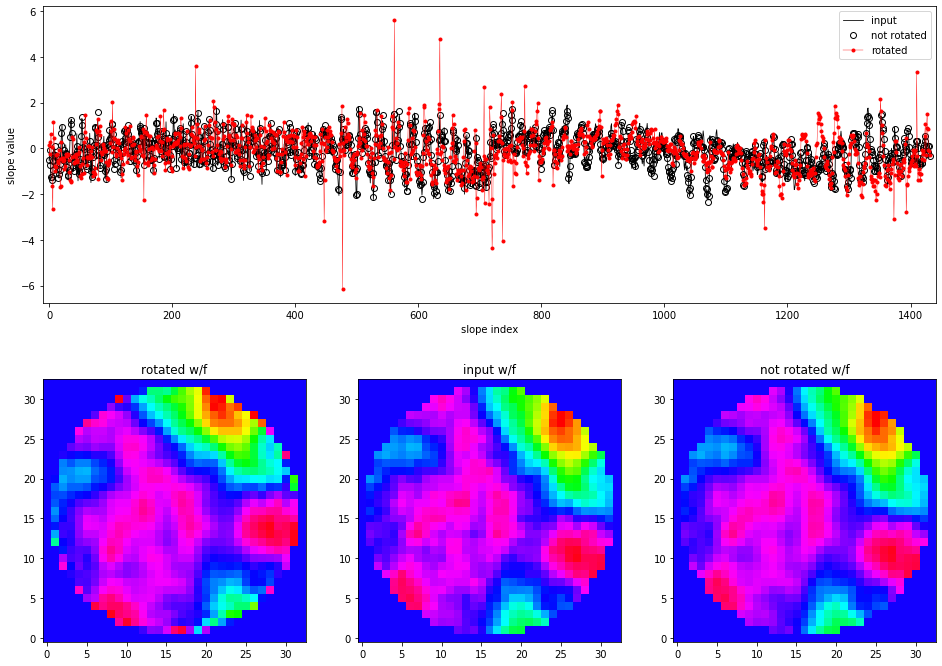

In [28]:
if 'fig2' in dir(): del fig2
fig2=pylab.figure(figsize=(16,12))
spst=pylab.subplot(2,1,1) # have to do it this way
spsl=pylab.subplot(2,3,4)
spsm=pylab.subplot(2,3,5)
spsr=pylab.subplot(2,3,6)
#
spst.plot(ip_slopesV,'k',lw=0.8, label='input')
spst.plot(norot_slopesV,'ko',markerfacecolor='none', label='not rotated')
spst.plot(rot_slopesV,'r.-',lw=0.4,label='rotated')
fac=1;lims=unrot_ap.min()*fac,unrot_ap.max()*fac
spsl.imshow( rot_ap,vmax=lims[1],vmin=lims[0], cmap='hsv' )
spsm.imshow( unrot_ap,vmax=lims[1],vmin=lims[0], cmap='hsv'  )
spsr.imshow( norot_ap,vmax=lims[1],vmin=lims[0], cmap='hsv'  )
#
spst.set_xlabel("slope index")
spst.set_ylabel("slope value")
spst.set_xlim(0-10,1431+10)
spst.legend(loc='best')
spsl.set_title("rotated w/f")
spsm.set_title("input w/f")
spsr.set_title("not rotated w/f");

# Rotation based on orthogonal slope functions

As we know that we can make functions based on analytic formulae (Zernike, Fourier basis) that can be rotated, this recipe is,
1. Generate the slopes for each function,
2. Orthogonalise these slopes,
3. Decompose the input slopes,
4. Reconstruct using the decomposition but onto rotated functions' slopes.

Below is a **Zernike** polynomial basis set, rotated

In [29]:
bM,rot_bM=[],[]
import Zernike
zernOrder=[]
iI,nI,mI,nModTwoI=0,1,2,3
for i in range(2,gOp.numberPhases//2+2):
    paramV=[i]+Zernike.zernNumToDegFreq(i) # order is; i,n,m,nModTwo
    paramV=[ paramV[idx] for idx in (nI,mI,nModTwoI,iI) ]
    zernOrder.append( paramV )

iI,nI,mI,nModTwoI=3,0,1,2 # 
    
# max_n=int((N+1))
# max_m=int((N+1)*numpy.pi/2)
zernOrder.sort()
for paramV in zernOrder:
    i,n,m=[paramV[idx] for idx in (iI,nI,mI)]
    if n>=max_n or m>=max_m:
#         continue
        pass
    bM.append(
        gM@Zernike.anyZernike(i,N+3,clip=0,rotation=-rot_angle/2).ravel().take(gOp.illuminatedCornersIdx) )
    rot_bM.append(
        gM@Zernike.anyZernike(i,N+3,clip=0,rotation=+rot_angle/2).ravel().take(gOp.illuminatedCornersIdx) )

Below is a **Fourier** series basis set, rotated

In [30]:
# aim is to decompose, and then recompose but with rotated basis functions
# can do this from b' by having c=rot(angle,b), and thus c'=c.LT^{-1} which won't be orthogonal

In [32]:
if not type(bM) is numpy.ndarray:
    bM,rot_bM=numpy.array(bM).T,numpy.array(rot_bM).T
##
bTb=bM.T@bM
bLM=numpy.linalg.cholesky(bTb)
svd_coff=3e-2
bLM_i=numpy.linalg.pinv(bLM,1e-2)
##
b_dashM,rb_dashM=bM@bLM_i.T,rot_bM@bLM_i.T
rotBFOpM=rb_dashM@b_dashM.T
norotBFOpM=b_dashM@b_dashM.T

## Results

In [33]:
ip_slopesV=gM@inputV
norot_slopesV=norotBFOpM@ip_slopesV
rot_slopesV=rotBFOpM@ip_slopesV
rot_opV=gM_i@rot_slopesV
norot_opV=gM_i@norot_slopesV#ip_slopesV
rot_ap*=0
norot_ap=rot_ap.copy()
rot_ap.ravel()[gOp.illuminatedCornersIdx]=rot_opV
norot_ap.ravel()[gOp.illuminatedCornersIdx]=norot_opV
unrot_ap.ravel()[gOp.illuminatedCornersIdx]=inputV
##
print(f"var{{I/P slopes}}={ip_slopesV.var():.3e}")
print(f"var{{rot slopes}}={rot_slopesV.var():.3e}")
print(f"var{{n/r slopes}}={norot_slopesV.var():.3e}")
#
print(f"var{{I/P w/front}}={inputV.var():.3e}")
print(f"var{{rot w/front}}={rot_opV.var():.3e}")
print(f"var{{n/r w/front}}={norot_opV.var():.3e}")


var{I/P slopes}=5.671e-01
var{rot slopes}=7.340e-01
var{n/r slopes}=5.257e-01
var{I/P w/front}=1.287e+01
var{rot w/front}=1.333e+01
var{n/r w/front}=1.281e+01


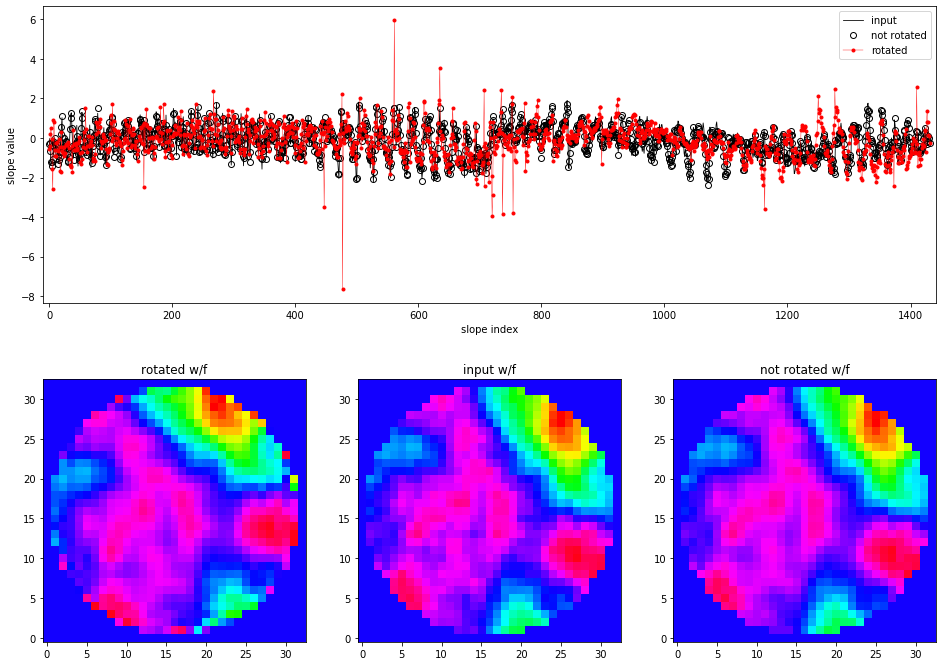

In [34]:
if 'fig1' in dir(): del fig1
fig1=pylab.figure(figsize=(16,12))
spst=pylab.subplot(2,1,1) # have to do it this way
spsl=pylab.subplot(2,3,4)
spsm=pylab.subplot(2,3,5)
spsr=pylab.subplot(2,3,6)
#
spst.plot(ip_slopesV,'k',lw=0.8, label='input')
spst.plot(norot_slopesV,'ko',markerfacecolor='none', label='not rotated')
spst.plot(rot_slopesV,'r.-',lw=0.4,label='rotated')
fac=1;lims=unrot_ap.min()*fac,unrot_ap.max()*fac
spsl.imshow( rot_ap,vmax=lims[1],vmin=lims[0], cmap='hsv' )
spsm.imshow( unrot_ap,vmax=lims[1],vmin=lims[0], cmap='hsv'  )
spsr.imshow( norot_ap,vmax=lims[1],vmin=lims[0], cmap='hsv'  )
#
spst.set_xlabel("slope index")
spst.set_ylabel("slope value")
spst.set_xlim(0-10,1431+10)
spst.legend(loc='best')
spsl.set_title("rotated w/f")
spsm.set_title("input w/f")
spsr.set_title("not rotated w/f");